In [2]:
from pymongo import MongoClient
import pandas as pd

# Ganti URI sesuai MongoDB kamu
client = MongoClient("mongodb://localhost:27017")
db = client["workout_db"]
collection = db["obesity"]

# Ambil data dan ubah ke DataFrame
data = pd.DataFrame(list(collection.find()))


In [5]:
# Cek data
print(data.columns)

# Encode Gender dan Obesity Category ke angka
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in ['Gender', 'PhysicalActivityLevel', 'ObesityCategory']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # simpan encoder untuk inverse nanti

# Pisahkan fitur dan label
X = data[['Age', 'Gender', 'Height', 'Weight', 'BMI', 'PhysicalActivityLevel']]
y = data['ObesityCategory']


Index(['Age', 'Gender', 'Height', 'Weight', 'BMI', 'PhysicalActivityLevel',
       'ObesityCategory'],
      dtype='object')


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


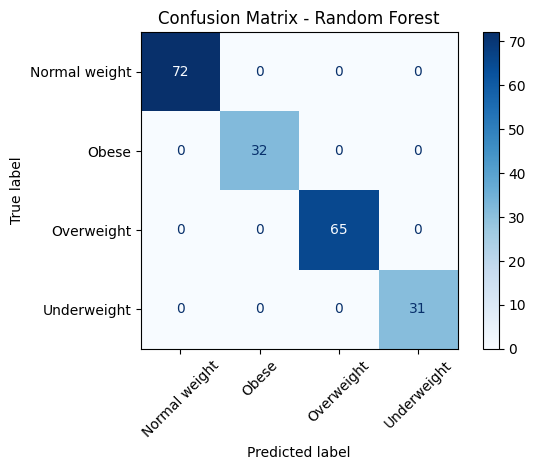

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ambil label aslinya
class_labels = label_encoders['ObesityCategory'].classes_

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=class_labels))


Accuracy: 1.0
               precision    recall  f1-score   support

Normal weight       1.00      1.00      1.00        72
        Obese       1.00      1.00      1.00        32
   Overweight       1.00      1.00      1.00        65
  Underweight       1.00      1.00      1.00        31

     accuracy                           1.00       200
    macro avg       1.00      1.00      1.00       200
 weighted avg       1.00      1.00      1.00       200



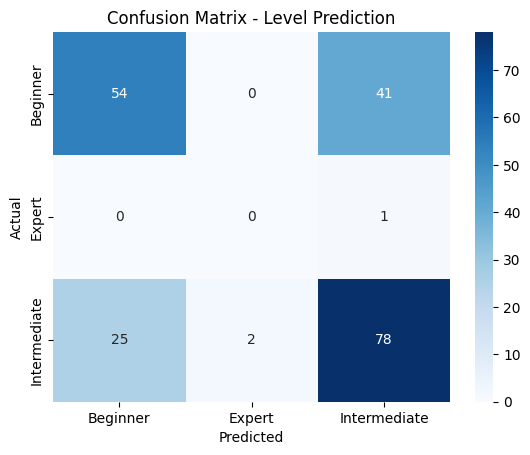

              precision    recall  f1-score   support

    Beginner       0.68      0.57      0.62        95
      Expert       0.00      0.00      0.00         1
Intermediate       0.65      0.74      0.69       105

    accuracy                           0.66       201
   macro avg       0.44      0.44      0.44       201
weighted avg       0.66      0.66      0.66       201



In [10]:
from pymongo import MongoClient
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Koneksi ke MongoDB
client = MongoClient("mongodb://localhost:27017")
db = client["workout_db"]
collection = db["workouts"]

# 2. Ambil data dari MongoDB
data = list(collection.find())
df = pd.DataFrame(data)

# 3. Pilih kolom yang relevan
df = df[['Type', 'BodyPart', 'Equipment', 'Rating', 'Level']]
df = df.dropna()  # hilangkan data kosong/null

# 4. Encode data kategori jadi angka
le_dict = {}
for col in ['Type', 'BodyPart', 'Equipment', 'Level']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # simpan encoder kalau mau dibalik lagi nanti

# 5. Split fitur dan label
X = df[['Type', 'BodyPart', 'Equipment', 'Rating']]
y = df['Level']

# 6. Split data train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Latih model Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)

# 8. Evaluasi model
y_pred = model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
label_names = le_dict['Level'].inverse_transform(sorted(y.unique()))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Level Prediction')
plt.show()

# Report
print(classification_report(y_test, y_pred, target_names=label_names))
